In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%run imports.py

In [3]:
# import tempfile
# tb_log_dir = tempfile.mkdtemp()
# user = os.getlogin()
# tb_log_dir = f'/tmp/tensorboard/{user}'
# print(tb_log_dir)


In [4]:
# if os.path.exists(tb_log_dir):
#     shutil.rmtree(tb_log_dir)

In [5]:
# logger = tb.SummaryWriter(tb_log_dir)

In [6]:
task = mnist.MNIST()
task.load_all_data(device)

In [12]:
torch.manual_seed(10)
model = models_pheno.ConvNet
net = model().to(device)
summary_kwargs = {'input_size': (task.bs_train, 1, 28, 28), 
                  'col_names': ["input_size", "output_size", "num_params", "kernel_size"]}
summary(net, **summary_kwargs)

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Kernel Shape
ConvNet                                  --                        --                        --                        --
├─Conv2d: 1-1                            [1000, 1, 28, 28]         [1000, 2, 26, 26]         20                        [1, 2, 3, 3]
├─Conv2d: 1-2                            [1000, 2, 13, 13]         [1000, 5, 11, 11]         95                        [2, 5, 3, 3]
├─Conv2d: 1-3                            [1000, 5, 5, 5]           [1000, 10, 3, 3]          460                       [5, 10, 3, 3]
├─Linear: 1-4                            [1000, 10]                [1000, 10]                110                       [10, 10]
Total params: 685
Trainable params: 685
Non-trainable params: 0
Total mult-adds (M): 27.21
Input size (MB): 3.14
Forward/backward pass size (MB): 16.46
Params size (MB): 0.00
Estimated Total Size (MB): 19.59

In [13]:
task.perform_stats(net, tqdm=tqdm, device=device);

Average Loss: 2.321, Accuracy: 7.670%


In [14]:
# opt = torch.optim.SGD(net.parameters(), lr=1e-1)
opt = torch.optim.Adam(net.parameters(), lr=1e-2)

In [15]:
for epoch in tqdm(range(10)):
    for batch_idx, (X_batch, Y_batch) in tqdm(enumerate(task.loader_train), 
                                              leave=False, total=len(task.loader_train)):
        X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
        Y_batch_pred = net(X_batch)
        loss = task.loss_func(Y_batch_pred, Y_batch)
        opt.zero_grad()
        loss.backward()
        opt.step()
    task.perform_stats(net, tqdm=tqdm, device=device)
    
    

Average Loss: 0.643, Accuracy: 80.920%


Average Loss: 0.440, Accuracy: 87.010%


Average Loss: 0.384, Accuracy: 88.530%


Average Loss: 0.347, Accuracy: 89.310%


Average Loss: 0.344, Accuracy: 90.080%


Average Loss: 0.318, Accuracy: 90.390%


Average Loss: 0.291, Accuracy: 91.480%


Average Loss: 0.291, Accuracy: 91.430%


Average Loss: 0.271, Accuracy: 92.000%


Average Loss: 0.263, Accuracy: 92.350%



In [16]:
task.perform_stats(net, loader=task.loader_train, tqdm=tqdm, device=device)
task.perform_stats(net, tqdm=tqdm, device=device)

Average Loss: 0.284, Accuracy: 91.678%


Average Loss: 0.263, Accuracy: 92.350%


{'loss': 0.2626867488026619, 'accuracy': 92.35}

In [17]:
fitdata = task.calc_pheo_fitness(net, n_sample=40000, device=device)

TypeError: calc_pheo_fitness() got an unexpected keyword argument 'n_sample'

In [40]:
import util
try:
    data = torch.load('./data/mnist_sgd_eval')
    weights = torch.load('./data/mnist_sgd_weights')
except:
    data = {}
    weights = {}
data.update({model: fitdata})
weights.update({model: util.model2vec(net)})
torch.save(data, './data/mnist_sgd_eval')
torch.save(weights, './data/mnist_sgd_weights')

In [45]:
for key, val in data.items():
    print(key.__name__, ': ', val)

BigConvNet :  {'fitness': -0.10598196089267731, 'loss': 0.10598196089267731, 'accuracy': 96.65}
SmallNet :  {'fitness': -0.6912355422973633, 'loss': 0.6912355422973633, 'accuracy': 78.32249999999999}
ConvNet :  {'fitness': -0.28138837218284607, 'loss': 0.28138837218284607, 'accuracy': 91.6425}


# Issue

I noticed that sometimes SmallNet does not train at all.
It is because the gradients are zero except for in the bias term in the last linear layer.
I do NOT know why this is happening even after a lot of debugging...

In [144]:
class SmallNet(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 1, kernel_size=3)
        self.conv2 = nn.Conv2d(1, 1, kernel_size=3)
        self.conv3 = nn.Conv2d(1, 1, kernel_size=3)
        self.fc1 = nn.Linear(9, 10)

    def forward(self, x):
        x = torch.relu(torch.max_pool2d(self.conv1(x), 2))
        x = torch.relu(torch.max_pool2d(self.conv2(x), 2))
        x = torch.relu(self.conv3(x))
        x = x.view(-1, 9)
        y = x
        x = self.fc1(x)
        return x.log_softmax(dim=-1)#, y, x

In [176]:
def train_net(net, n_epochs, lr=1e-2, verbose=True):
    opt = torch.optim.Adam(net.parameters(), lr=lr)
    loss_func = nn.NLLLoss()
    for epoch in range(n_epochs):
        for batch_idx, (X_batch, Y_batch) in enumerate(task.loader_train):
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
            Y_batch_pred = net(X_batch)
            loss = loss_func(Y_batch_pred, Y_batch)
            opt.zero_grad()
            loss.backward()
            opt.step()
#             for p in net.parameters():
#                 print(tuple(p.shape), p.requires_grad, p.grad.abs().mean().item())
#                 p.data -= lr * p.grad
#             print()
        if verbose:
            task.perform_stats(net, tqdm=None, device=device, verbose=verbose)


In [201]:
data = []
for seed in tqdm(range(30)):
    model = models_pheno.BigConvNet
    torch.manual_seed(seed);np.random.seed(seed)
    verbose = False
    net_1 = model().to(device)
    print('\n\n\nTraining net 1')
    train_net(net_1, 5, verbose=verbose)
    s1 = task.perform_stats(net_1, tqdm=None, device=device, verbose=verbose)
    print('\n\n\nTraining net 2')
    net_2 = model().to(device)
    train_net(net_2, 5, verbose=verbose)
    s2 = task.perform_stats(net_2, tqdm=None, device=device, verbose=verbose)

    vec_1 = util.model2vec(net_1)
    vec_2 = util.model2vec(net_2)
    net_3 = model().to(device)
#     vec_3 = util.uniform_crossover(vec_1, vec_2)
    vec_3 = ((vec_1+vec_2)/2.).detach()
    net_3 = util.vec2model(vec_3, net_3)


    print('\n\n\nTraining net 3')
#     task.perform_stats(net_3, tqdm=None, device=device, verbose=verbose)
    train_net(net_3, 5, verbose=verbose)
    s3 = task.perform_stats(net_3, tqdm=None, device=device, verbose=verbose)
    
    print(s1, s2, s3)
    
    data.append([s1, s2, s3])




Training net 1



Training net 2



Training net 3
{'loss': 0.1467772752046585, 'accuracy': 95.48} {'loss': 0.1782861739397049, 'accuracy': 94.46} {'loss': 0.15313244760036468, 'accuracy': 95.44}



Training net 1



Training net 2



Training net 3
{'loss': 0.17113252431154252, 'accuracy': 94.88} {'loss': 0.1374105244874954, 'accuracy': 95.89999999999999} {'loss': 0.11068749576807022, 'accuracy': 96.7}



Training net 1



Training net 2



Training net 3
{'loss': 0.16568519920110703, 'accuracy': 95.03} {'loss': 0.21094172745943068, 'accuracy': 93.66} {'loss': 0.13197394087910652, 'accuracy': 95.92}



Training net 1



Training net 2



Training net 3
{'loss': 0.10938413068652153, 'accuracy': 96.91} {'loss': 0.16407122910022737, 'accuracy': 95.07} {'loss': 0.10204129740595817, 'accuracy': 96.97}



Training net 1



Training net 2



Training net 3
{'loss': 0.1550750717520714, 'accuracy': 95.07} {'loss': 0.17099241316318511, 'accuracy': 94.83} {'loss': 0.15034525990486144, 'accura

In [243]:
plt.rcParams.update({
    "figure.facecolor":  (1.0, 1.0, 1.0, 1.0),  # red   with alpha = 30%
    "axes.facecolor":    (1.0, 1.0, 1.0, 1.0),  # red   with alpha = 30%
    "savefig.facecolor": (1.0, 1.0, 1.0, 1.0),  # red   with alpha = 30%
})

0.8719999999999999+-1.2514642091033485
1.2003333333333306+-1.4415673954260868


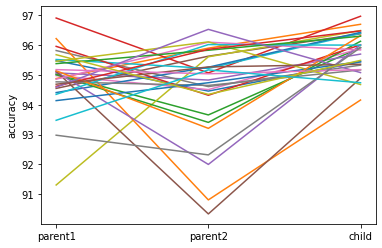

In [245]:
a = MultiArr(util.arr_dict2dict_arr(np.array(data)))['accuracy'].T
plt.plot(a); plt.xticks(range(3), ['parent1', 'parent2', 'child']); plt.ylabel('accuracy')
b = a[2]-a[0]
print(f'{b.mean()}+-{b.std()}')
b = a[2]-a[1]
print(f'{b.mean()}+-{b.std()}')



In [181]:
import xarray as xr

In [190]:
data = xr.DataArray(np.random.randn(2, 3, 3), 
                    dims=('crossover', 'agent', 'metric'), 
                    coords={'crossover': ['uniform', 'mean'],
                            'agent': ['parent1', 'parent2', 'child'],
                            'metric': ['fitness', 'loss', 'accuracy']})

In [194]:
data.loc['uniform', 'parent1', 'fitness'] = 0